In [3]:
import os
import logging
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import statsmodels.api as sm

import scipy.stats as stats
from scipy.stats import norm, zscore, friedmanchisquare

import scikit_posthocs as sp

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score,
    explained_variance_score
)

import joblib

In [3]:
# Define start and end date
start_date = '2015-01-01 00:00:00'
end_date = '2023-12-31 23:59:59'

# Function to prepare datasets
def prepare_dataset(df, start_date, end_date):
    # Create a copy of the DataFrame
    df = df.copy()
    
    # Convert Timestamp to datetime and set as index
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
    df.set_index('Timestamp', inplace=True)
    
    # Slice the time period right after setting the index
    df = df[start_date:end_date].copy()
    
    # Remove timestamp duplicates (keep the first entry)
    df = df[~df.index.duplicated(keep='first')]
    
    # Convert all numeric columns to float
    for column in df.select_dtypes(include=['object']).columns:
        try:
            df.loc[:, column] = df[column].astype(float)
        except ValueError:
            print(f"Could not convert column {column} to float")
    
    return df

# Import and prepare the datasets
air_quality = pd.read_csv('dataset/Veenkampen_Air Quality.csv', skiprows=[1])
air_quality = prepare_dataset(air_quality, start_date, end_date)

meteorology = pd.read_csv('dataset/Veenkampen_Meteorology.csv', skiprows=[1])
meteorology = prepare_dataset(meteorology, start_date, end_date)

soil = pd.read_csv('dataset/Veenkampen_Soil.csv', skiprows=[1])
soil = prepare_dataset(soil, start_date, end_date)

# Import and prepare the flux dataset
fluxes = pd.read_csv('./dataset/Veenkampen_Fluxes.csv', skiprows=[1]) # Remove units row
fluxes = prepare_dataset(fluxes, start_date, end_date)

# Show information about all prepared datasets
print("\nTime range of datasets:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\n{name}:")
    print(f"Start: {df.index.min()}")
    print(f"End: {df.index.max()}")
    print(f"Number of data points: {len(df)}")

# Show dataset info
print("\nDataset Infos:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\n{name} Dataset Info:")
    print(df.info())

# Check for missing values
print("\nMissing values:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\nMissing values in {name}:")
    print(df.isnull().sum())

# Check sampling rates
print("\nSampling intervals:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\n{name}:")
    print(df.index.to_series().diff().value_counts().head())


Time range of datasets:

Air Quality:
Start: 2015-01-01 00:00:00
End: 2023-12-31 23:56:00
Number of data points: 979527

Meteorology:
Start: 2015-01-01 00:00:00
End: 2023-12-31 23:59:00
Number of data points: 4720489

Soil:
Start: 2015-01-01 00:00:00
End: 2023-12-31 23:59:00
Number of data points: 4717918

Fluxes:
Start: 2015-01-01 00:00:00
End: 2023-12-31 23:30:00
Number of data points: 140422

Dataset Infos:

Air Quality Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 979527 entries, 2015-01-01 00:00:00 to 2023-12-31 23:56:00
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   co2_mixing_ratio  130219 non-null  float64
 1   h2o_mixing_ratio  140145 non-null  float64
 2   BC                362135 non-null  float64
 3   NOx               646041 non-null  float64
 4   NO                646041 non-null  float64
 5   NO2               646041 non-null  float64
 6   O3                628638

In [3]:
# Load dataset (Ensure the correct data path is used)
data = fluxes['co2_flux'].copy()

# 1. Basic descriptive analysis of CO2 flux values
print("=== Descriptive Statistics ===")
print(data.describe())

# 2. Outlier detection using the Interquartile Range (IQR) method
q1, q3 = data.quantile([0.25, 0.75])
iqr = q3 - q1
iqr_low = q1 - 1.5 * iqr  # Lower bound for moderate outliers
iqr_high = q3 + 1.5 * iqr  # Upper bound for moderate outliers

print(f"\nIQR-based thresholds: [{iqr_low:.2f}, {iqr_high:.2f}] µmol/m²/s")

# 3. Defining alternative thresholds using the 5th and 95th percentiles
p05, p95 = data.quantile([0.05, 0.95])
print(f"\n95% range: [{p05:.2f}, {p95:.2f}] µmol/m²/s")



# Approach 1: IQR-based filtering
clean_data_iqr = data.where(
    (data >= iqr_low) & 
    (data <= iqr_high)
)

# Approach 2: 95%-based filtering
clean_data_95 = data.where(
    (data >= p05) & 
    (data <= p95)
)

# Compare data retention after filtering
print(f"\nRemaining data after filtering (IQR applied): {clean_data_iqr.count() / len(data):.1%}")
print(f"Remaining data after filtering (95% range applied): {clean_data_95.count() / len(data):.1%}")

=== Descriptive Statistics ===
count    1.302190e+05
mean     6.126728e+06
std      1.579221e+09
min     -5.072780e+02
25%     -5.093183e+00
50%      5.899440e-01
75%      3.217230e+00
max      4.559529e+11
Name: co2_flux, dtype: float64

IQR-based thresholds: [-17.56, 15.68] µmol/m²/s

95% range: [-14.81, 11.78] µmol/m²/s

Remaining data after filtering (IQR applied): 86.2%
Remaining data after filtering (95% range applied): 83.5%


## Interpolation of missing values in the CO2 flux data

Statistics of cleaned co2_flux (outliers removed):
count    117194.000000
mean         -0.718166
std           5.479319
min         -14.799859
25%          -4.354316
50%           0.591012
75%           2.861450
max          11.798248
Name: co2_flux_clean, dtype: float64


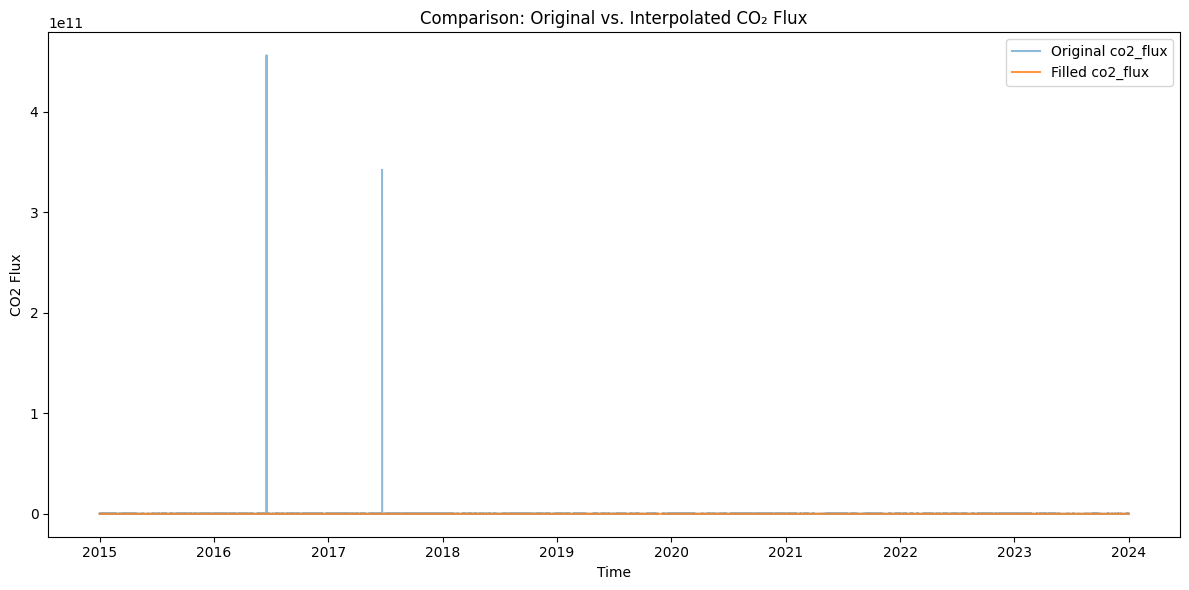


Statistics of filled co2_flux:
count    140422.000000
mean         -0.727028
std           5.538167
min         -14.799859
25%          -4.394530
50%           0.597171
75%           2.905169
max          11.798248
Name: co2_flux_filled, dtype: float64


In [4]:
# Set the random seed for reproducibility
np.random.seed(42)


# ---------------------------------
# 0. Preparation: Interpolation of solar radiation data
# ---------------------------------
# The variable SW_IN_1_1_1 from the meteorology dataset is used for day/night determination.
# Interpolate missing values in SW_IN_1_1_1 using time-based interpolation.
meteorology['SW_IN_1_1_1'] = meteorology['SW_IN_1_1_1'].interpolate(method='time', limit_direction='both')

# To align solar radiation data with flux timestamps, reindex the meteorological SW_IN values 
# to match the flux dataset's time grid using the nearest method, as meteorological data is at 1-minute intervals.
flux_df = fluxes.copy()
flux_df['SW_IN'] = meteorology['SW_IN_1_1_1'].reindex(flux_df.index, method='nearest')

# ---------------------------------
# 1. Statistical analysis and outlier removal of CO₂ flux data
# ---------------------------------
# Copy the original CO₂ flux data into a new column
flux_df['co2_flux_clean'] = flux_df['co2_flux'].copy()

# Set values outside the 95% range (less than -14.8 or greater than 11.8) as outliers to NaN
flux_df.loc[(flux_df['co2_flux_clean'] < -14.8) | (flux_df['co2_flux_clean'] > 11.8), 'co2_flux_clean'] = np.nan

print("Statistics of cleaned co2_flux (outliers removed):")
print(flux_df['co2_flux_clean'].describe())

# ---------------------------------
# 2. Preparation for interpolation: Differentiating between short and long gaps
# ---------------------------------
# Determine the typical sampling interval in hours (median of time differences)
median_interval = flux_df.index.to_series().diff().median().total_seconds() / 3600.0

# Perform an initial linear time interpolation to fill all gaps
flux_df['co2_flux_lin'] = flux_df['co2_flux_clean'].interpolate(method='time', limit_direction='both')

# Identify indices of gaps longer than 1.5 hours
na_mask = flux_df['co2_flux_clean'].isna()
group_ids = (na_mask != na_mask.shift()).cumsum()
missing_groups = flux_df[na_mask].groupby(group_ids)

long_gap_indices = []
for group_id, group in missing_groups:
    # Compute the gap duration (difference between first and last timestamp plus one typical interval)
    gap_duration = (group.index[-1] - group.index[0]).total_seconds() / 3600.0 + median_interval
    if gap_duration > 1.5:
        long_gap_indices.extend(group.index)

# Reset values in the linearly interpolated series to NaN for long gaps
flux_df.loc[long_gap_indices, 'co2_flux_lin'] = np.nan

# ---------------------------------
# 3. Definition of day/night determination using solar radiation
# ---------------------------------
# Daytime is assumed when SW_IN > 0 W/m², otherwise, it is considered nighttime.
def is_day(timestamp):
    # Use the interpolated SW_IN value from the flux dataset for the given timestamp.
    # If the value is missing, default to nighttime.
    sw_value = flux_df.at[timestamp, 'SW_IN'] if pd.notnull(flux_df.at[timestamp, 'SW_IN']) else 0
    return sw_value > 0

# ---------------------------------
# 4. Gap filling using Marginal Distribution Sampling (MDS)
# ---------------------------------
# For each timestamp in long gaps, a random value is drawn from the empirical distribution of cleaned CO₂ flux data,
# based on whether it is day or night.
for ts in long_gap_indices:
    if is_day(ts):
        # Select all valid values in the daytime period (SW_IN > 0)
        pool = flux_df.loc[flux_df['SW_IN'] > 0, 'co2_flux_clean'].dropna()
    else:
        # Select all valid values in the nighttime period (SW_IN <= 0)
        pool = flux_df.loc[flux_df['SW_IN'] <= 0, 'co2_flux_clean'].dropna()
    
    if len(pool) > 0:
        flux_df.at[ts, 'co2_flux_lin'] = np.random.choice(pool.values)
    else:
        flux_df.at[ts, 'co2_flux_lin'] = np.nan

# The combined result (linear interpolation for short gaps, MDS for long gaps) 
# is stored in the column 'co2_flux_filled'.
flux_df['co2_flux_filled'] = flux_df['co2_flux_lin']

# ---------------------------------
# 5. Interpolation of external variables in the flux dataset
# ---------------------------------
# Perform a simple time interpolation for all other variables with missing values.
cols_to_exclude = ['co2_flux', 'co2_flux_clean', 'co2_flux_lin', 'co2_flux_filled', 'SW_IN']
external_cols = [col for col in flux_df.columns if col not in cols_to_exclude]

if external_cols:
    flux_df[external_cols] = flux_df[external_cols].interpolate(method='time', limit_direction='both')

# ---------------------------------
# 6. Visualization and final statistics
# ---------------------------------
plt.figure(figsize=(12, 6))
plt.plot(flux_df.index, flux_df['co2_flux'], label='Original co2_flux', alpha=0.5)
plt.plot(flux_df.index, flux_df['co2_flux_filled'], label='Filled co2_flux', alpha=0.8)
plt.xlabel("Time")
plt.ylabel("CO2 Flux")
plt.title("Comparison: Original vs. Interpolated CO₂ Flux")
plt.legend()
plt.tight_layout()
plt.show()

print("\nStatistics of filled co2_flux:")
print(flux_df['co2_flux_filled'].describe())


## Fill gaps in the dataset after CO2 flux interpolation

In [5]:


# Logging configuration
logging.basicConfig(
    filename='gap_filling.log', 
    level=logging.DEBUG, 
    format='%(asctime)s - %(levelname)s - %(message)s', 
    filemode='a'
)
logger = logging.getLogger()

def fill_gaps_mds(df, col_original, condition_pool_func, gap_threshold_hours=1.5):
    """
    Fills gaps in a time series based on linear interpolation and MDS for long gaps.
    """
    missing_before = df[col_original].isna().sum()
    logger.info(f"{col_original}: Missing values before interpolation: {missing_before}")
    
    col_lin = col_original + '_lin'
    col_filled = col_original + '_filled'
    df[col_lin] = df[col_original].interpolate(method='time', limit_direction='both')
    
    na_mask = df[col_original].isna()
    group_ids = (na_mask != na_mask.shift()).cumsum()
    missing_groups = df[na_mask].groupby(group_ids)
    
    median_interval = df.index.to_series().diff().median().total_seconds() / 3600.0
    long_gap_indices = []
    for group_id, group in missing_groups:
        gap_duration = (group.index[-1] - group.index[0]).total_seconds() / 3600.0 + median_interval
        if gap_duration > gap_threshold_hours:
            long_gap_indices.extend(group.index)
    
    df.loc[long_gap_indices, col_lin] = np.nan
    
    for ts in long_gap_indices:
        pool = condition_pool_func(df, ts, col_original)
        if len(pool) > 0:
            df.at[ts, col_lin] = np.random.choice(pool.values)
        else:
            df.at[ts, col_lin] = np.nan
    
    df[col_filled] = df[col_lin]
    
    missing_after = df[col_filled].isna().sum()
    logger.info(f"{col_filled}: Missing values after gap filling: {missing_after}")
    
    return df

def meteo_pool(df, ts, col_original):
    current_hour = ts.hour
    pool = df[df.index.hour == current_hour][col_original].dropna()
    if pool.empty:
        pool = df[col_original].dropna()
    return pool

# Determine the relevant datasets for interpolation
meteorology = meteorology if 'meteorology' in locals() else None
soil = soil if 'soil' in locals() else None
flux_df = flux_df if 'flux_df' in locals() else None

datasets = {'meteorology': meteorology,
            'soil': soil,
            }

# Apply interpolation to relevant variables and add them to flux_df
for dataset_name, dataset in datasets.items():
    if dataset is not None:
        if dataset_name == 'meteorology':
            target_cols = ['TA_1_1_1', 'RH_1_1_1', 'WS_1_1_1', 'SW_IN']
        elif dataset_name == 'soil':
            target_cols = ['TS_1_1_1']
        else:
            target_cols = []
        for col in target_cols:
            if col in dataset.columns:
                logger.info(f"Applying MDS to {col} in {dataset_name}...")
                dataset = fill_gaps_mds(dataset, col, meteo_pool, gap_threshold_hours=1.5)
                datasets[dataset_name] = dataset  # Update the dataset
                
                # Add interpolated values to flux_df
                flux_df[col] = dataset[col + '_filled'].reindex(flux_df.index, method='nearest')
                logger.info(f"Added interpolated values of {col} to flux_df.")

# Assemble the feature set
logger.info("Assembling features...")
features = ['SW_IN', 'sin_hour', 'cos_hour', 'sin_day', 'cos_day', 'is_day',
            'co2_flux_lag1', 'co2_flux_lag24', 'co2_flux_rolling_mean_6h', 'co2_flux_rolling_mean_24h']
if 'TA_1_1_1' in flux_df.columns:
    features.extend(['TA_1_1_1', 'temp_radiation_interaction'])
if 'RH_1_1_1' in flux_df.columns:
    features.append('RH_1_1_1')
if 'WS_1_1_1' in flux_df.columns:
    features.append('WS_1_1_1')
logger.info(f"Feature list assembled: {features}")

## Start Random Forest Analysis

### Feature Engineering
### This is also the final Model

In [6]:


# ------------------------
# Define Feature Sets
# ------------------------
feature_sets = [
    ['SW_IN', 'TS_1_1_1'],
    ['SW_IN', 'TS_1_1_1', 'co2_flux_lag1'],
    ['SW_IN', 'TS_1_1_1', 'co2_flux_lag1', 'co2_flux_lag24'],
    ['SW_IN', 'TS_1_1_1', 'co2_flux_rolling_mean_6h'],
    ['SW_IN', 'TS_1_1_1', 'co2_flux_rolling_mean_6h', 'co2_flux_rolling_mean_24h'],
    ['SW_IN', 'TS_1_1_1', 'sin_hour', 'cos_hour'],
    ['SW_IN', 'TS_1_1_1', 'sin_day', 'cos_day'],
    ['SW_IN', 'TS_1_1_1', 'TA_1_1_1', 'temp_radiation_interaction'],
    ['SW_IN', 'TS_1_1_1', 'co2_flux_lag1', 'co2_flux_lag24', 'sin_hour', 'cos_hour', 'sin_day', 'cos_day'],
    ['SW_IN', 'TS_1_1_1', 'co2_flux_lag1', 'co2_flux_lag24', 'co2_flux_rolling_mean_6h', 'co2_flux_rolling_mean_24h', 'TA_1_1_1', 'temp_radiation_interaction'],
    [
    'sin_hour', 'cos_hour', 'sin_day', 'cos_day',
    'SW_IN', 'is_day',
    'co2_flux_lag1', 'co2_flux_lag24',
    'co2_flux_rolling_mean_6h', 'co2_flux_rolling_mean_24h',
    'TA_1_1_1', 'temp_radiation_interaction',
    'RH_1_1_1', 'WS_1_1_1', 'TS_1_1_1'
]
]

# ------------------------
# Feature Engineering
# ------------------------
def apply_feature_engineering(df, features):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_year'] = df.index.dayofyear

    if 'sin_hour' in features:
        df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
    if 'cos_hour' in features:
        df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
    if 'sin_day' in features:
        df['sin_day'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    if 'cos_day' in features:
        df['cos_day'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

    if 'is_day' in features:
        df['is_day'] = (df['SW_IN'] > 0).astype(int)
    if 'co2_flux_lag1' in features:
        df['co2_flux_lag1'] = df['co2_flux_filled'].shift(1)
    if 'co2_flux_lag24' in features:
        df['co2_flux_lag24'] = df['co2_flux_filled'].shift(24)
    if 'co2_flux_rolling_mean_6h' in features:
        df['co2_flux_rolling_mean_6h'] = df['co2_flux_filled'].rolling(window=6).mean()
    if 'co2_flux_rolling_mean_24h' in features:
        df['co2_flux_rolling_mean_24h'] = df['co2_flux_filled'].rolling(window=24).mean()
    if 'temp_radiation_interaction' in features:
        if 'TA_1_1_1' in df.columns:
            df['temp_radiation_interaction'] = df['TA_1_1_1'] * df['SW_IN']

    return df

# ------------------------
# Main Evaluation Routine
# ------------------------
from copy import deepcopy
from tqdm import tqdm

# Store best
all_errors = []
feature_set_names = []
best_r2 = -np.inf
best_features = None

# Timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
log_filename = f'randomforest_features_{timestamp}.log'
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(
    filename=log_filename,
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filemode='w'
)
logger = logging.getLogger()
logger.info("Starting Random Forest feature evaluation...")

for i, feature_list in enumerate(tqdm(feature_sets, desc="Feature Sets")):
    logger.info(f"\n--- Running Random Forest with Feature Set {i+1}: {feature_list} ---")

    df = apply_feature_engineering(flux_df, feature_list)
    df.dropna(inplace=True)

    X = df[feature_list]
    y = df['co2_flux_filled']

    train_size = int(0.8 * len(X))
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    param_grid = {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5]
    }

    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=tscv, scoring='r2', n_jobs=10)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Save error vector for this feature set
    fs_name = f"FS_{i+1}"
    abs_errors = np.abs(y_test.values - y_pred)
    all_errors.append(abs_errors)
    feature_set_names.append(fs_name)
    logger.info(f"Absolute errors for {fs_name}: {abs_errors.tolist()}")

    logger.info(f"MAE: {mae:.4f}")
    logger.info(f"RMSE: {rmse:.4f}")
    logger.info(f"R²: {r2:.4f}")

    if r2 > best_r2:
        best_r2 = r2
        best_features = deepcopy(feature_list)

logger.info(f"\n=== Best Feature Set ===")
logger.info(f"Features: {best_features}")
logger.info(f"Best R²: {best_r2:.4f}")

# ------------------------
# Save all errors as CSV
# ------------------------

# Build DataFrame with errors (columns = feature sets, rows = timesteps)
max_len = max(len(e) for e in all_errors)
errors_df = pd.DataFrame({name: pd.Series(err) for name, err in zip(feature_set_names, all_errors)})

csv_path = os.path.join(os.getcwd(), f"rf_feature_errors_{timestamp}.csv")
errors_df.to_csv(csv_path, index=False)
print(f"Test errors saved to: {csv_path}")



Feature Sets:   0%|          | 0/11 [00:00<?, ?it/s]/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Feature Sets:   9%|▉         | 1/11 [06:54<1:09:00, 414.02s/it]/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Feature Sets:  18%|█▊        | 2/11 [16:51<1:18:18, 522.05s/it]/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnin

Test errors saved to: /Users/olegattow/mastersthesis/code/python/rf_feature_errors_20250606_174016.csv


ValueError: Array shapes are incompatible for broadcasting.

## Friedman Test + Nemenyi Post-hoc Test

In [ ]:

csv_path = "rf_feature_errors_20250606_174016.csv"
df = pd.read_csv(csv_path)
df = df.dropna(axis=1, how="all")

# === Prepare error matrix: truncate all columns to the shortest length ===
min_len = min(df[col].dropna().shape[0] for col in df.columns)
all_errors_equal = [df[col].dropna().values[:min_len] for col in df.columns]
errors_matrix = pd.DataFrame(all_errors_equal).T  # Transponiert für posthocs

# === 1. Friedman Test ===
stat, p = friedmanchisquare(*all_errors_equal)
print(f"Friedman test statistic: {stat:.3f}, p-value: {p:.4g}")

if p < 0.05:
    print("There is a significant difference between feature sets (Friedman test).")
    # === 2. Nemenyi Post-hoc Test ===
    nemenyi = sp.posthoc_nemenyi_friedman(errors_matrix)
    print("\nNemenyi Post-hoc p-value matrix:")
    print(nemenyi)
else:
    print("No significant difference between feature sets (Friedman test).")

Friedman test statistic: 11621.302, p-value: 0
There is a significant difference between feature sets (Friedman test).

Nemenyi Post-hoc p-value matrix:
           0             1             2             3             4  \
0   1.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1   0.000000  1.000000e+00  6.763479e-13  0.000000e+00  9.005760e-01   
2   0.000000  6.763479e-13  1.000000e+00  1.466460e-04  0.000000e+00   
3   0.000000  0.000000e+00  1.466460e-04  1.000000e+00  0.000000e+00   
4   0.000000  9.005760e-01  0.000000e+00  0.000000e+00  1.000000e+00   
5   0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
6   0.496329  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
7   0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
8   0.000000  1.166985e-03  2.147043e-02  1.720846e-14  3.892833e-07   
9   0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
10  0.000000  0.000000e+00  0.000000e+00  0.000000e+00 

## Random Forest on whole Feature Set

In [6]:

# Logging configuration
logging.basicConfig(
    filename='random_forest_analysis.log', 
    level=logging.DEBUG, 
    format='%(asctime)s - %(levelname)s - %(message)s', 
    filemode='a'
)
logger = logging.getLogger()

logger.info("Starting data preparation...")

# ------------------------------
# Advanced Feature Engineering
# ------------------------------

# 1. Time-based features (daily and yearly cycles)
logger.info("Creating time-based features...")
flux_df['hour'] = flux_df.index.hour
logger.debug("Feature 'hour' created.")
flux_df['sin_hour'] = np.sin(2 * np.pi * flux_df['hour'] / 24)
logger.debug("Feature 'sin_hour' created.")
flux_df['cos_hour'] = np.cos(2 * np.pi * flux_df['hour'] / 24)
logger.debug("Feature 'cos_hour' created.")

flux_df['day_of_year'] = flux_df.index.dayofyear
logger.debug("Feature 'day_of_year' created.")
flux_df['sin_day'] = np.sin(2 * np.pi * flux_df['day_of_year'] / 365)
logger.debug("Feature 'sin_day' created.")
flux_df['cos_day'] = np.cos(2 * np.pi * flux_df['day_of_year'] / 365)
logger.debug("Feature 'cos_day' created.")

# 2. Day/night indicator based on solar radiation
logger.info("Creating day/night indicator...")
flux_df['is_day'] = (flux_df['SW_IN'] > 0).astype(int)
logger.debug("Feature 'is_day' created.")

# 3. Lag features for CO2 flux
logger.info("Creating lag features...")
flux_df['co2_flux_lag1'] = flux_df['co2_flux_filled'].shift(1)
logger.debug("Feature 'co2_flux_lag1' created.")
flux_df['co2_flux_lag24'] = flux_df['co2_flux_filled'].shift(24)
logger.debug("Feature 'co2_flux_lag24' created.")

# 4. Moving averages
logger.info("Creating moving averages...")
flux_df['co2_flux_rolling_mean_6h'] = flux_df['co2_flux_filled'].rolling(window=6).mean()
logger.debug("Feature 'co2_flux_rolling_mean_6h' created.")
flux_df['co2_flux_rolling_mean_24h'] = flux_df['co2_flux_filled'].rolling(window=24).mean()
logger.debug("Feature 'co2_flux_rolling_mean_24h' created.")

# 5. Meteorological variables
if 'TA_1_1_1' in flux_df.columns:
    logger.info("Adding temperature-radiation interaction feature...")
    flux_df['temp_radiation_interaction'] = flux_df['TA_1_1_1'] * flux_df['SW_IN']
    logger.debug("Feature 'temp_radiation_interaction' created.")

# Remove NaN values
logger.info("Checking for missing values and removing them...")
flux_df.dropna(inplace=True)
logger.info(f"Missing values removed. Remaining number of rows: {len(flux_df)}")

# Assemble feature set
logger.info("Assembling features...")
features = [
    'sin_hour', 'cos_hour', 'sin_day', 'cos_day',
    'SW_IN', 'is_day',
    'co2_flux_lag1', 'co2_flux_lag24',
    'co2_flux_rolling_mean_6h', 'co2_flux_rolling_mean_24h'
]
if 'TA_1_1_1' in flux_df.columns:
    features.extend(['TA_1_1_1', 'temp_radiation_interaction'])
if 'RH_1_1_1' in flux_df.columns:
    features.append('RH_1_1_1')
if 'WS_1_1_1' in flux_df.columns:
    features.append('WS_1_1_1')
if 'TS_1_1_1' in flux_df.columns:
    features.append('TS_1_1_1')
logger.info(f"Feature list assembled: {features}")

X = flux_df[features]
y = flux_df['co2_flux_filled']

# ------------------------------
# Train-test split
# ------------------------------
logger.info("Splitting data into training and test sets with 80:20 ratio...")
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
logger.info(f"Training set size: {len(X_train)}, Test set: {len(X_test)}")

# ------------------------------
# Advanced Hyperparameter Optimization
# ------------------------------
logger.info("Starting GridSearch for hyperparameter tuning...")
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5]
}
logger.debug(f"param grid: {param_grid}")

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=tscv, scoring='r2', n_jobs=10)
logger.info("Starting GridSearchCV...")
grid_search.fit(X_train, y_train)
logger.info("GridSearch completed.")
logger.info(f"Best parameters: {grid_search.best_params_}")
logger.info(f"Best R² score (training set): {grid_search.best_score_}")


# Evaluation of the best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

logger.info("Evaluation of the best model after GridSearch:")
logger.info(f"Mean Squared Error (MSE): {mse_best}")
logger.info(f"Root Mean Squared Error (RMSE): {rmse_best}")
logger.info(f"R² score: {r2_best}")

try:
        # Get current timestamp and format it
        current_time = datetime.now()
        timestamp_str = current_time.strftime("%Y%m%d_%H%M%S") # Format: YYYYMMDD_HHMMSS

        # Create filename
        model_filename = f"best_random_forest_model_{timestamp_str}.joblib"

        # Save model with joblib
        joblib.dump(best_rf, model_filename)

        logger.info(f"Best model successfully saved to: {model_filename}")

except Exception as e:
        logger.error(f"Error while saving the model: {e}")

/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


## Evaluation of Random Forest model on Saved Model


--- Evaluation Metrics on Test Set (last 20% of 2015–2023) ---
MSE: 7.8768
RMSE: 2.8066
NRMSE: 0.1055
MAE: 1.7488
MedAE: 0.9806
R2: 0.7431
Explained Var: 0.7431
MBE: -0.0059
R: 0.8620
MAPE: 178.81%
sMAPE: 60.26%


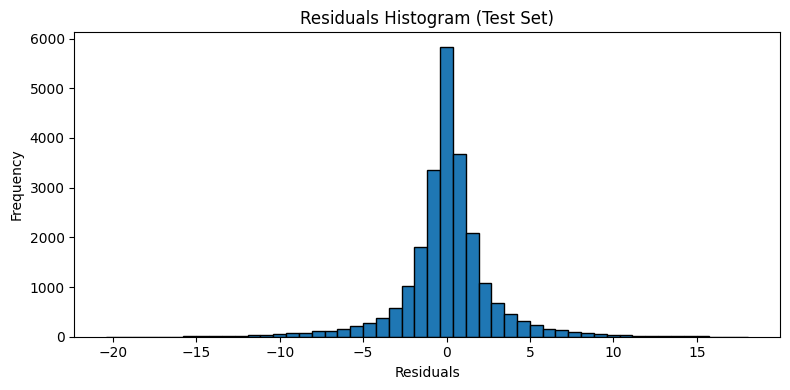

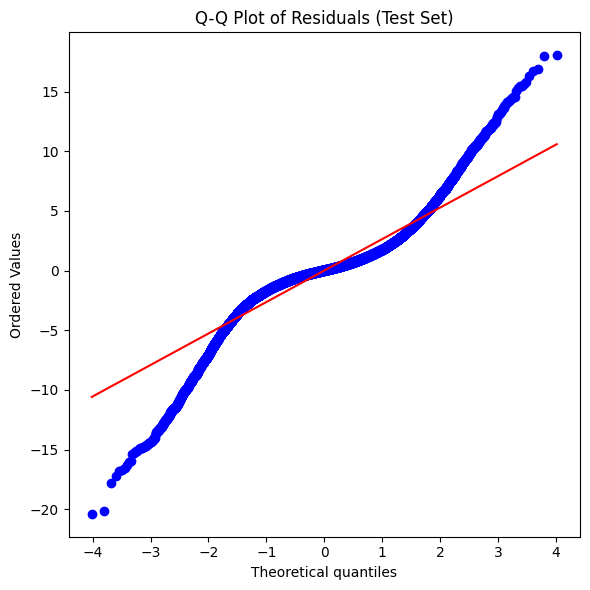

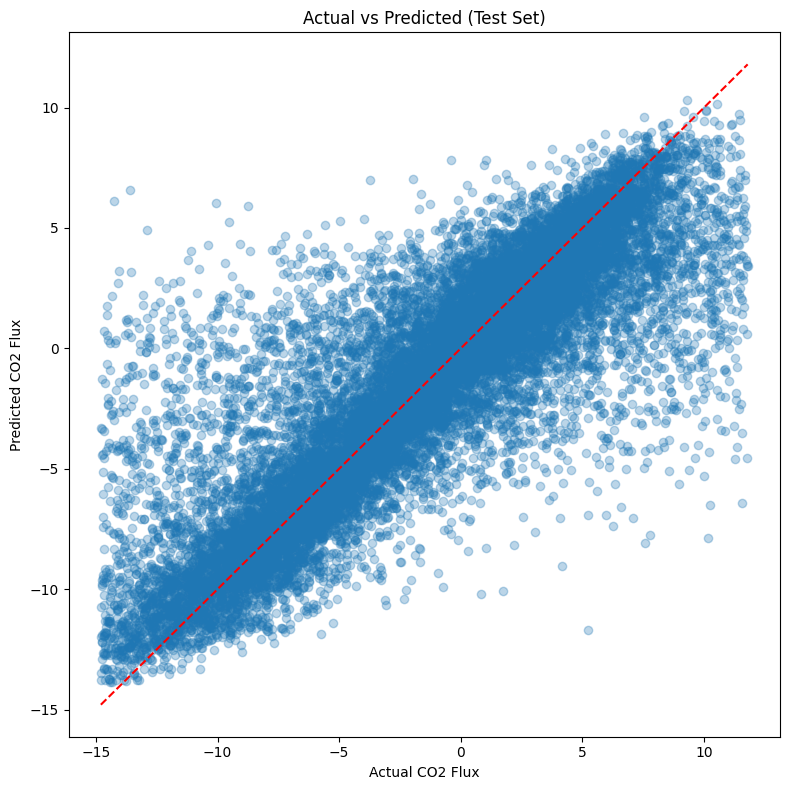

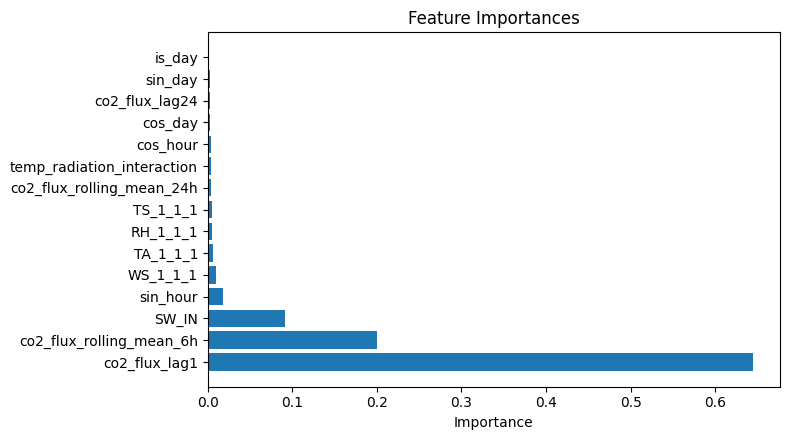

co2_flux_lag1: 0.6444
co2_flux_rolling_mean_6h: 0.2003
SW_IN: 0.0915
sin_hour: 0.0179
WS_1_1_1: 0.0097
TA_1_1_1: 0.0068
RH_1_1_1: 0.0049
TS_1_1_1: 0.0048
co2_flux_rolling_mean_24h: 0.0043
temp_radiation_interaction: 0.0037
cos_hour: 0.0033
cos_day: 0.0032
co2_flux_lag24: 0.0028
sin_day: 0.0023
is_day: 0.0000


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Decisio

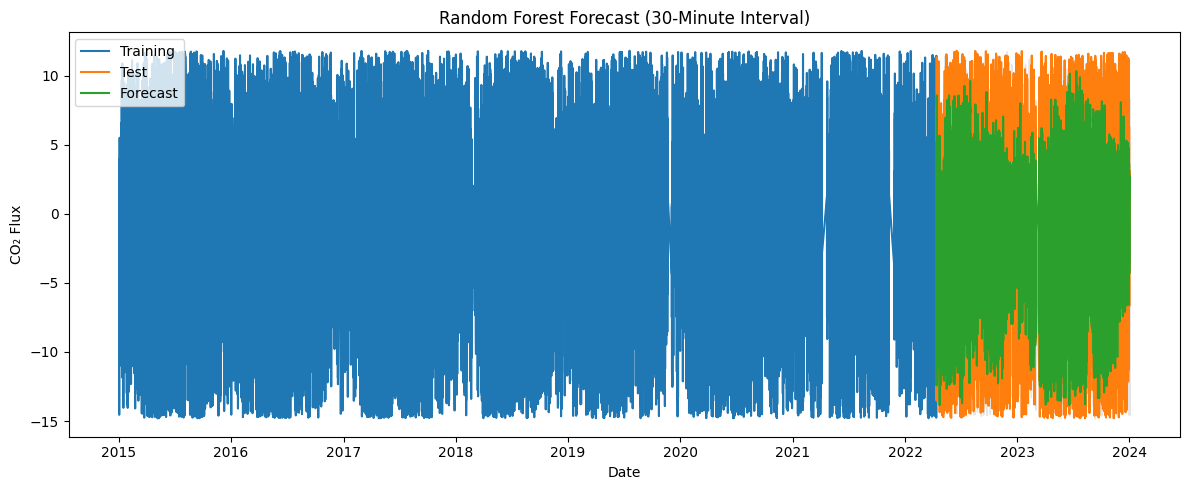


--- Metrics for Day (Test Set) ---
RMSE: 2.6507
MAE: 1.7152
MAPE: 130.77%
R2: 0.7411

--- Metrics for Night (Test Set) ---
RMSE: 2.9795
MAE: 1.7885
MAPE: 235.32%
R2: 0.4283


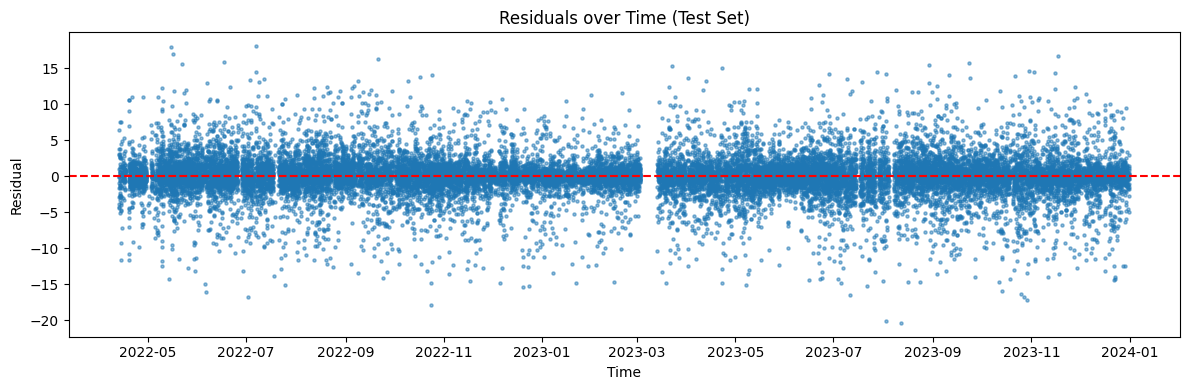

/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


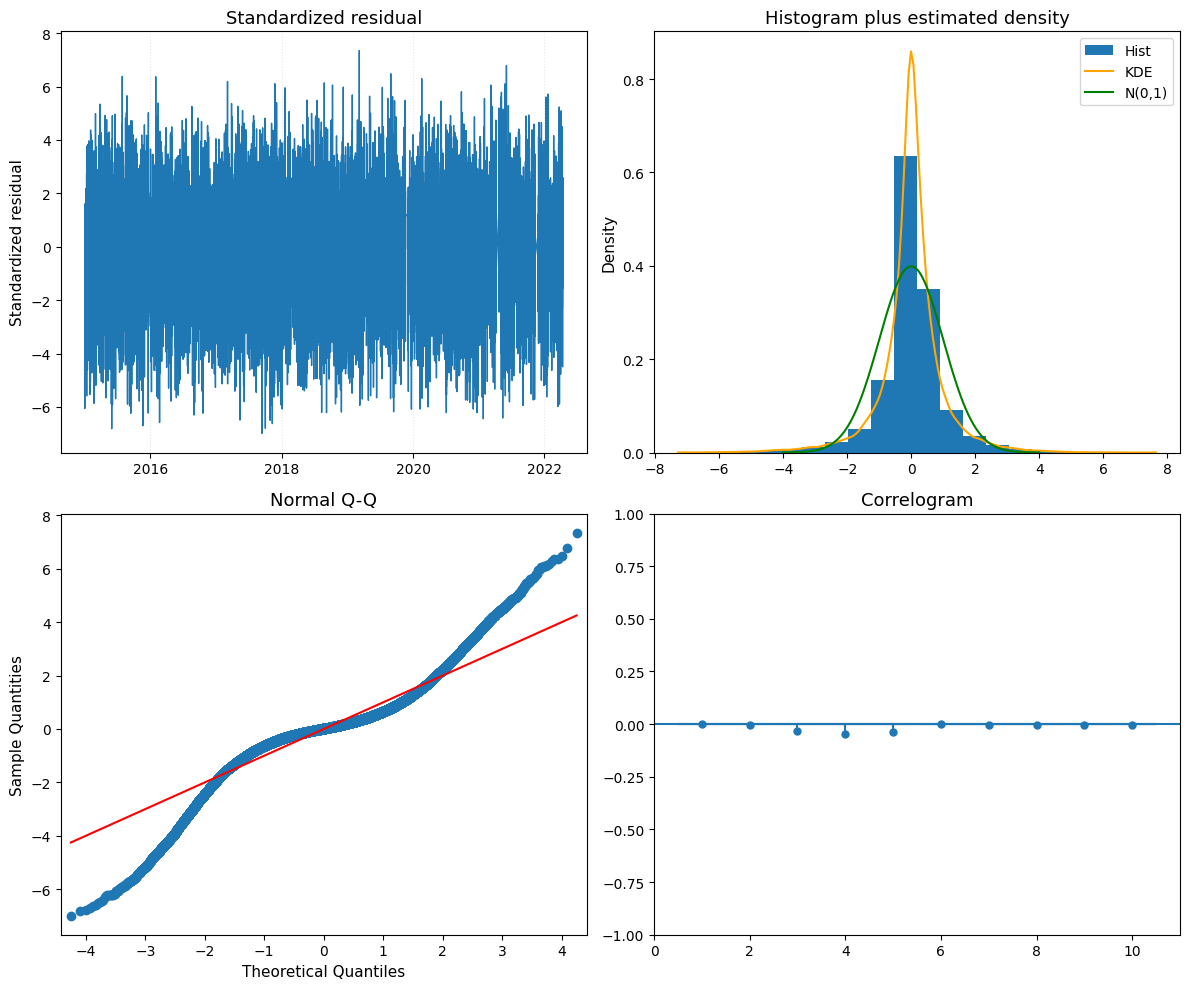

In [14]:


# Configure logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

# --- Load trained model ---
model_path = "best_random_forest_model_20250516_201506.joblib"
best_rf: RandomForestRegressor = joblib.load(model_path)
logger.info(f"Loaded RandomForest model from {model_path}")

# --- Prepare data (2015-2023) ---
# Assume flux_df (with datetime index) and features list are available.
if not isinstance(flux_df.index, pd.DatetimeIndex):
    flux_df.index = pd.to_datetime(flux_df.index)

# Sort by datetime just in case
flux_df = flux_df.sort_index()

# Define features and target
X = flux_df[features]
y = flux_df['co2_flux_filled']

# Train/test split: 80% train, 20% test (chronological split)
N = len(flux_df)
train_size = int(0.8 * N)

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Check for NaNs
if X_test.isnull().any().any():
    logger.warning("NaNs found in test feature matrix X_test. Consider imputation.")
if X_train.isnull().any().any():
    logger.warning("NaNs found in train feature matrix X_train. Consider imputation.")

# --- Predictions ---
logger.info("Generating predictions for test set (last 20% of data)...")
y_test_pred = best_rf.predict(X_test)
residuals = y_test - y_test_pred

# --- Evaluation Metrics ---
metrics = {}
metrics['MSE'] = mean_squared_error(y_test, y_test_pred)
metrics['RMSE'] = np.sqrt(metrics['MSE'])
metrics['NRMSE'] = metrics['RMSE'] / (y_test.max() - y_test.min())
metrics['MAE'] = mean_absolute_error(y_test, y_test_pred)
metrics['MedAE'] = median_absolute_error(y_test, y_test_pred)
metrics['R2'] = r2_score(y_test, y_test_pred)
metrics['Explained Var'] = explained_variance_score(y_test, y_test_pred)
metrics['MBE'] = np.mean(y_test_pred - y_test)
metrics['R'] = np.corrcoef(y_test, y_test_pred)[0,1]
metrics['MAPE'] = np.mean(np.abs((y_test - y_test_pred) / np.where(y_test != 0, y_test, np.nan))) * 100
metrics['sMAPE'] = 100 * np.mean(
    2 * np.abs(y_test_pred - y_test) /
    np.where((np.abs(y_test) + np.abs(y_test_pred)) != 0,
             np.abs(y_test) + np.abs(y_test_pred), np.nan)
)

# --- Print metrics ---
print("\n--- Evaluation Metrics on Test Set (last 20% of 2015–2023) ---")
for name, val in metrics.items():
    if name in ['MAPE', 'sMAPE']:
        print(f"{name}: {val:.2f}%")
    else:
        print(f"{name}: {val:.4f}")

# OOB Score if available
if hasattr(best_rf, 'oob_score_') and best_rf.oob_score_:
    print(f"OOB Score: {best_rf.oob_score_:.4f}")

# --- Residual Diagnostics ---
# Histogram of residuals
plt.figure(figsize=(8,4))
plt.hist(residuals, bins=50, edgecolor='black')
plt.title('Residuals Histogram (Test Set)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Q-Q plot of residuals
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Test Set)')
plt.tight_layout()
plt.show()

# --- Actual vs Predicted Scatter ---
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_test_pred, alpha=0.3)
minv, maxv = y_test.min(), y_test.max()
plt.plot([minv, maxv], [minv, maxv], '--', color='red')
plt.xlabel('Actual CO2 Flux')
plt.ylabel('Predicted CO2 Flux')
plt.title('Actual vs Predicted (Test Set)')
plt.tight_layout()
plt.show()

# --- Feature Importance ---
importances = best_rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(8, len(features)*0.3))
plt.barh(np.array(features)[sorted_idx], importances[sorted_idx])
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Feature Importances
importances = best_rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

# Liste der Features mit ihren Importanzen
feature_importance_list = [(features[i], importances[i]) for i in sorted_idx]

# Ausgabe der Liste
for feature, importance in feature_importance_list:
    print(f"{feature}: {importance:.4f}")

# --- Forecast and Confidence Interval Plot (30-Minute Interval) ---

all_tree_preds = np.stack([tree.predict(X_test) for tree in best_rf.estimators_], axis=1)
conf_int = np.percentile(all_tree_preds, [2.5, 97.5], axis=1).T  # shape: (n_samples, 2)

forecast = y_test_pred

plt.figure(figsize=(12, 5))
plt.plot(y_train.index, y_train, label='Training')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, forecast, label='Forecast')
plt.fill_between(y_test.index, conf_int[:, 0], conf_int[:, 1], color='k', alpha=0.1)
plt.legend()
plt.title('Random Forest Forecast (30-Minute Interval)')
plt.xlabel('Date')
plt.ylabel('CO₂ Flux')
plt.tight_layout()
plt.show()

# --- Day/Night Comparative Metrics on Test Set (if applicable) ---
if 'is_day' in X_test.columns:
    df_eval = pd.DataFrame({
        'actual': y_test,
        'predicted': y_test_pred,
        'residual': residuals,
        'is_day': X_test['is_day']
    }, index=y_test.index)

    groups = {
        'Day': df_eval[df_eval['is_day'] == 1],
        'Night': df_eval[df_eval['is_day'] == 0]
    }

    for period, grp in groups.items():
        print(f"\n--- Metrics for {period} (Test Set) ---")
        y_act, y_pr = grp['actual'], grp['predicted']
        res = grp['residual']
        m = {
            'RMSE': np.sqrt(mean_squared_error(y_act, y_pr)),
            'MAE': mean_absolute_error(y_act, y_pr),
            'MAPE': np.mean(np.abs((y_act - y_pr)/np.where(y_act!=0,y_act,np.nan))) * 100,
            'R2': r2_score(y_act, y_pr)
        }
        for k,v in m.items():
            print(f"{k}: {v:.4f}" if k!='MAPE' else f"{k}: {v:.2f}%")

    # Time series plot of residuals
    plt.figure(figsize=(12,4))
    plt.scatter(df_eval.index, df_eval['residual'], s=5, alpha=0.5)
    plt.axhline(0, linestyle='--', color='red')
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.title('Residuals over Time (Test Set)')
    plt.tight_layout()
    plt.show()


# Calculate standardized residuals on the training data
train_residuals = y_train - best_rf.predict(X_train)
std_train_residuals = zscore(train_residuals, nan_policy='omit')

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.35, wspace=0.25)

# 1. Standardized residuals over time (top left)
ax = axes[0, 0]
ax.plot(y_train.index, std_train_residuals, color='tab:blue', linewidth=1)
ax.set_title("Standardized residual", fontsize=13)
ax.set_ylabel("Standardized residual", fontsize=11)
ax.set_xlabel("")
locator = mdates.AutoDateLocator(minticks=4, maxticks=8)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.grid(axis='x', which='major', linestyle=':', alpha=0.3)
ax.set_facecolor('white')

# 2. Histogram plus estimated density (top right)
ax = axes[0, 1]
ax.hist(std_train_residuals, bins=20, density=True, color='tab:blue', label='Hist')
sns.kdeplot(std_train_residuals, ax=ax, color='orange', label="KDE")
x_vals = np.linspace(-4, 4, 200)
ax.plot(x_vals, norm.pdf(x_vals), color="green", label="N(0,1)")
ax.set_title("Histogram plus estimated density", fontsize=13)
ax.set_ylabel("Density", fontsize=11)
ax.legend(loc='best', fontsize=10)
ax.set_facecolor('white')

# 3. Normal Q-Q plot (bottom left)
ax = axes[1, 0]
sm.qqplot(std_train_residuals, line='s', ax=ax, color='tab:blue')
ax.set_title("Normal Q-Q", fontsize=13)
ax.set_xlabel("Theoretical Quantiles", fontsize=11)
ax.set_ylabel("Sample Quantities", fontsize=11)
ax.set_facecolor('white')

# 4. Correlogram (bottom right)
ax = axes[1, 1]
sm.graphics.tsa.plot_acf(std_train_residuals, ax=ax, lags=10, zero=False, alpha=0.05)
ax.set_title("Correlogram", fontsize=13)
ax.set_facecolor('white')

plt.tight_layout()
plt.show()
logger.info("Full evaluation complete.")